<a id="0"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Libraries ~ ~ ~ ~</p>

In [ ]:
# Matrix and Arrays
import numpy as np
import pandas as pd

# Random
import random

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Signal
from scipy.fftpack import rfft, irfft, fftfreq, fft
from scipy.signal import butter, sosfilt, sosfreqz, filtfilt
from scipy.signal import hilbert
import cv2

# Audio
import librosa
import librosa.display
import IPython.display as ipd
# import noisereduce as nr

# Sklearn
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

# Pytorch
import torch
import torchaudio

# Math
from math import ceil

# Files
import os
import json

from tqdm.auto import tqdm
from functools import partial
from joblib import Parallel, delayed


#image
from PIL import Image as im

import imageio

# Warnings
import warnings
warnings.simplefilter('ignore')

from skimage.util import img_as_ubyte
from sklearn import preprocessing

<a id="1"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Introduction ~ ~ ~ ~</p>

This notebook implements one of the pipelines for audio transformation to Spectograms developed for the BirdCLEF 2022 competition where our team achieve the Bronze medal in 68th position. 


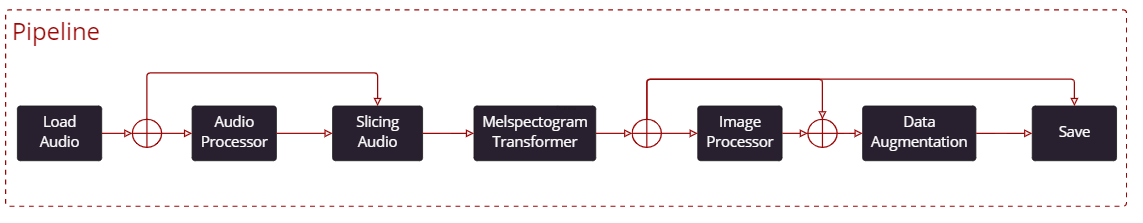

The pipeline consists of the transformation of a audio file into N melspectogram images. Some treatments into the audio\image and image augmentation can be applyied during the process:
* [1) Loading the audio files](#3-2)
* [2) Applying audio treatment or noise reduce (optional)](#5)
* [3) Break the audio file into slices of x seconds](#9)
* [4) Transform the audio slice into a spectogram (optional)](#4)
* [5) Applying some image treatment (optional)](#6)
* [6) Augment the melspectogram (optional)](#7)
* [7) Save original and augmented images](#8)
* [8) Result example](#15)

The blocks are done separately in classes, and put together in the pipeline class.  
All the control parameters are can be acessed in the [Configuration Class](#3) section

<a id="3"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Configuration Class ~ ~ ~ ~</p>
[back top](#1)

In [ ]:
#==================================================================================
# Configuration Class
#----------------------------------------------------------------------------------
class Configuration:
    
    def __init__(self):

        ################# in\out paths
        self.dir_path = '../input/birdclef-2022/train_audio'
        self.save_path = './'
        self.ext_save = 'png'
        self.orig = './'

        # Scored birds
        self.meta_data_path = '../input/birdclef-2022/train_metadata.csv'
        self.scored_birds    = pd.read_json('../input/birdclef-2022/scored_birds.json')[0].values
        self.filter_birds   = True
        
        ######### Loader Audio 
        self.duration    = 60
        self.sample_rate = 22050
        self.is_mono     = True
        
        ################ Audio Processor
        #_noise_reduction
        self.n_fft_a = 2048
        self.win_length_a = 1024
        self.use_tqdm_a = False
        #_limit_threshold
        self.rate_a = 1.5
        #_low_pass
        self.lowcut_a = 955
        self.highcut_a = 8005
        self.order_a=5
        #Hilbert 
        self.hilbert = False
        
        ################### Spectogram
        #image - Spect
        self.frame_size = 5 # seg
        self.frame_step = 5  # seg
        
        # Spectogram Transformer
        # Default Spec (librosa)
        self.hop_length  = 128
        self.frame_size_t  = 256
        
        #Mel spect (Torch)
        self.n_mels     = 250
        self.n_fft      = 2048
        self.win_length = 1024
        self.f_min      = 500
        self.f_max      = 9000
        
        ###################### Image Processor
        self.kernel_e_i = np.ones((2,2),np.uint8)
        self.iteration_e_i = 2
        
        self.kernel_d_i = np.ones((3,3),np.uint8)
        self.iteration_d_i = 2
        
        ################  Data Augmentation
        self.max_ite = 4
        self.force_tras_1 = True
        
        #mix up 1
        self.mix_imgs = 3
        
        #################### Padding
        self.padValue = 2
        self.minTime = 5
        
        self.birds_to_filter = ['apapan']
       
        #beta
        self.th_bird_files = 200
        self.device = 'cpu'


<a id="3-2"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Load Audio ~ ~ ~ ~</p>

- In this section is presented the class that loads the audio files into arrays using the librosa library

[back top](#1)

In [ ]:
#==================================================================================
# Load Audio 
#----------------------------------------------------------------------------------

class LoadAudio(Configuration):
    """Load Imagem from path"""
    
    def __init__(self):
        super().__init__()
        
    def load(self, path):
        wave, _  =  librosa.load(path, 
                              sr = self.sample_rate,
                              mono = self.is_mono,
                              )
        
        wave_params = self._getParameters(wave)

        return wave, wave_params
    
    def _getParameters(self, wave):
        N = len(wave)                                     # Number of samples
        T = 1.0 / self.sample_rate                        # period
        x_t = np.linspace(0.0, N*T, N)                    # Time
        x_f = np.linspace(0.0, 1.0/(2.0*T), int(N/2))     # frequencies
        
        return (N, T, x_t, x_f)


class getFiles(Configuration):
    def __init__(self):
        super().__init__()
        
    def run(self):
        path = []
        for base, dirs, files in os.walk(self.dir_path):
        #     print('Searching in : ',base)
            for d in (dirs):

                for i in os.listdir((self.dir_path+'/'+ d)):
                    path.append(d+'/'+i)
    
        if self.birds_to_filter:
            path = [p for p in path for bird in self.birds_to_filter if p.startswith(bird) ]
            
        return path


<a id="2"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Meta Data ~ ~ ~ ~</p>

- In this section the class reads the meta data dataframe and used as base to process the files and filters  
[back top](#1)

In [ ]:
#==================================================================================
# Meta data Processor 
#---------------------------------------------------------------------------------- 
class Process_meta(Configuration):

    def __init__(self):
        super().__init__()
        
    def read(self):
        self.train_meta = pd.read_csv(self.meta_data_path)
        if self.filter_birds:
            self._filter_birds()
        if True:
            self.setFileName()
    
    def _filter_birds(self):
        self.train_meta = self.train_meta[self.train_meta['primary_label'].isin(self.scored_birds)]
        
    def _getFiles(self):
        return self.train_meta['filename'].values
    
    def _getTrain_meta(self):
        return self.train_meta

    def setFileName(self):
        self.train_meta['name_f'] = self._getTrain_meta()['filename'].apply(lambda x:( x.split('/')[1].split('.')[0]))


<a id="4"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Spectogram Trasnformers ~ ~ ~ ~</p>

- In this section is presented the different spectograms transformers avaliable
    - Spectogram
    - Melspectogram
    - CPEN Melsptogram  
  
[back top](#1)

In [ ]:
#==================================================================================
# Spectogram Transformers 
#----------------------------------------------------------------------------------
class SpectogramaTransformer_librosa(Configuration):
    
    def __init__(self):
        super().__init__()
        
    def transform(self, wave):
        spectrogram = librosa.stft(wave,
                            n_fft=self.frame_size_t,
                            hop_length=self.hop_length)[:-1]
        
#         spectrogram = np.abs(spectrogram)
#         db_spectrogram = librosa.amplitude_to_db(spectrogram)
        return spectrogram


class CPENSpectoramTransformer_librosa(Configuration):
    def __init__(self):
        super().__init__()

    def transform(self, melspect):
        spectogram = librosa.pcen(melspect * (2 ** 31), 
                                  eps = 1e-6,
                                  gain = 0.8,
                                  power = 0.25,
                                  bias = 10, 
                                  sr = self.sample_rate,
                                  hop_length = self.hop_length)
        return spectogram




class melSpectogramTransformer_torch(Configuration):
    
    def __init__(self):
        super().__init__()
    
    def transform(self,wave):
        transfomer = torchaudio.transforms.MelSpectrogram(sample_rate = self.sample_rate,
                                                         n_fft = self.n_fft, 
                                                         win_length = self.win_length,
                                                         n_mels = self.n_mels,
                                                         f_min = self.f_min,
                                                         f_max = self.f_max ).double().to(self.device)
        

        wave = torch.from_numpy(wave.copy()).to(self.device)
        
        mel_spectrogram = transfomer(wave)
        mel_spectrogram = np.array(mel_spectrogram)
        
        return mel_spectrogram
 


<a id="5"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Audio Processor ~ ~ ~ ~</p>
[back top](#1)

In [ ]:
# #==================================================================================
# # Audio Processor  (Done externaly)
# #----------------------------------------------------------------------------------
# class Audio_Processer(Configuration):
    
#     def __init__(self):
#         super().__init__()
        
#     def run(self, wave, params):
        
#         wave = (self._remove_continuous_component(wave))
#         wave = (self._normalization(wave))
#         wave = (self._noise_reduction(wave))
#         #freq_cut = fft(self._limit_threshold(wave, params))
#         wave = (self._low_filter(wave))
# #         wave, wave_hb = (self._hilbert_transform(wave))

#         if self.hilbert:
#             return wave_hb
#         return wave
    
#     def _remove_continuous_component(self, y_t):
#         return y_t  - np.mean(y_t)
    
#     def _normalization(self,y_t):
#         return y_t/np.max(y_t)

#     def _noise_reduction(self, y_t):
#         y_ = nr.reduce_noise(y = y_t,
#                             sr = self.sample_rate,
#                             n_fft = self.n_fft_a,
#                             win_length = self.win_length_a,
#                             use_tqdm = self.use_tqdm_a,
#                             n_jobs = 2)

#         return np.array(y_)
    
#     def _limit_threshold(self,y_t, params):
#         N, T, x_t, x_f = params
        
#         y_f = fft(y_t)
#         y_f = 2.0/N * np.abs(y_f[:N//2])
#         mean_yf = np.mean(y_f)
#         std_yf = np.std(y_f)
#         distances = np.power(y_f - mean_yf, 2) 
#         index = distances.argmin()

#         if x_f[index]*taxa >= np.max(x_f):
#             freq_cut = np.max(x_f)*0.95
#         else:
#             freq_cut = x_f[index]*self.rate_a 

#         return freq_cut
    
#     def _low_filter(self,y_t):
#         nyq = 0.5 * self.sample_rate
#         low = self.lowcut_a / nyq
#         high = self.highcut_a / nyq
#         b, a = butter(self.order_a, [low, high], btype='bandpass', analog=False, output='ba')
#         y_ = filtfilt(b, a, y_t)

#         return y_
    
#     def _hilbert_transform(self,y_t):
#         analytical_signal = hilbert(y_t)
#         y_ = np.abs(analytical_signal)
#         hilbert_fft = fft(y_)
#         return y_, hilbert_fft





<a id="6"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Image Processor ~ ~ ~ ~</p>

- This section implements some image processaments:
    - erosion
    - dilation
 
[back top](#1)

In [ ]:

#==================================================================================
# Image Processor 
#----------------------------------------------------------------------------------
class Image_processor(Configuration):
    def __init__(self):
        super().__init__()
        
    def transform(self, spect):
        
        spect_type_ori =  type(spect)
        spect = self._setSpecType(spect, np.ndarray)
        
        spect = self._erosion(spect)
        spect = self._dilation(spect)
        
        spect = self._setSpecType(spect, spect_type_ori)
        
        return spect
    
    def _erosion(self, spect):
        img_erosion = cv2.erode(spect, self.kernel_e_i, self.iteration_e_i)
        return img_erosion
    
    def _dilation(self, spect):
        img_dilate = cv2.dilate(spect, self.kernel_d_i, self.iteration_d_i)
        return img_dilate
    
    def _setSpecType(self, spect, to_type):
        
        if to_type == np.ndarray:
            return np.array(spect)
        elif to_type == torch.Tensor:
            return torch.from_numpy(spect)
        else:
            print("error")
        

<a id="7"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Data Augmentation ~ ~ ~ ~</p>

- This section inplements strategies of data augmentation:
    - time mask
    - frequency mask
    - mixup

[back top](#1)

In [ ]:
#==================================================================================
# Data Augmentation 
#----------------------------------------------------------------------------------
class Data_augmentation_spect(Configuration):
    
    def __init__(self):
        super().__init__()
        
    
    def run_masks(self, spect):
        prob = np.random.random(2)
#         transformations_list = [self._time_mask, self._freq_mask]
        transformations_list = [self._freq_mask]

        transformations = [i for (i, v) in zip(transformations_list, prob > 0.5) if v]
        
        #at least one
        if ((not transformations) & (self.force_tras_1)):
            transformations = [(transformations_list[np.random.randint(len(transformations_list))])]
        
#         print(f'Transformations:{len(transformations)}')
        spect = torch.from_numpy(spect.copy())
        for t in transformations:
            
            spect = t(spect)
            
        return spect
        
    
    def _time_mask(self, spect):
        it = np.random.randint(0,(self.max_ite+1))
        for i in range(it):
            value = (20 - 10) * np.random.random_sample() + 10
            t1 = torchaudio.transforms.TimeMasking(time_mask_param= value)
            
            spect = t1(spect)
            
        return spect
    
    def _freq_mask(self, spect):
        it = np.random.randint(0,(self.max_ite+1))
        for i in range(it):
            value = (20 - 10) * np.random.random_sample() + 10
            t2 = torchaudio.transforms.FrequencyMasking(freq_mask_param = value)
            spect = t2(spect)
        return spect

    def mixUp(self,spect_list):
        if len(spect_list) >=3:
            selected   = np.random.choice(range(0, len(spect_list)), 3,replace = False)
            spect_list =  [spect_list[i] for i in selected]
            mix_spect = sum(spect_list)
            return mix_spect,selected
        return spect_list[0],0
            
    def mixUp_2(self,spect_list):
        
        selected   = np.random.choice(range(0, len(spect_list)), self.mix_imgs,replace = False)
        spect_list =  [spect_list[i] for i in selected]
        
        lam = np.clip(np.random.beta(3,3),0.3,0.7)
        lam_shuffle = 1-lam
        mix_spect = lam*spect_list[0] + lam_shuffle*spect_list[1]
        return mix_spect,selected

<a id="8"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Save Function ~ ~ ~ ~</p>

This section implements the save class to save all the image generate in the pipeline.  
[back top](#1)

In [ ]:
#=====================================================================
# Saver class
#---------------------------------------------------------------------
class Saver(Configuration):
    def __init__(self):
        super().__init__()
    
    
    def init_save_folder(self):
        if not os.path.exists(self.save_path):
            os.mkdir(self.save_path)
    
    def new_folder(self, folder):
        if not os.path.exists((self.save_path +'/'+folder)):
            os.mkdir((self.save_path +'/' + folder))
            
    def save_image(self, img, folder, name, t = 'jpg'):
        self.new_folder(folder)
        file_path = self.save_path + '/' + folder + '/' + name + '.' + t
        print(f'saving...{file_path}')
        # imageio.imwrite(file_path,img) #funcionando
        np.save(file_path, img)
        # np.savez_compressed(file_path, img)


class slicing_by_qt(Configuration):
    
    def __init__(self):
        super().__init__()
        
    def generate_data(self):
        audio_num_birds = {}
        for base, dirs, files in os.walk(self.dir_path):
        #     print('Searching in : ',base)
            for d in (dirs):
                Audio_num_birds[d] = [0]
                for i in os.listdir((self.dir_path + '/' + d)):
                    Audio_num_birds[d][0]+=1

        data = pd.DataFrame.from_dict(Audio_num_birds, 'index', columns =['count'])
        data['high'] = data['count'].apply(lambda x: 1 if x > self.th_bird_files else 0)
        return data


<a id="9"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Pipeline ~ ~ ~ ~</p>

- This section presents the pipeline class. It is possible to pass different classes that implements other types of functions in the processors\tranformers\augmentation. 
- Also, the pipeline class implements some usefull methods to print images, padding the audio or get files names.
  
[back top](#1)

In [ ]:
#==================================================================================
# Pipeline 
#----------------------------------------------------------------------------------
class ProcessingPipiline(Configuration):
    """Main Class of the processing birds songs"""
        
    
    def __init__(self):
        super().__init__()
        self.meta_processor = None
        self.audio_treater = None
        self.spect_transformer = None
        self.cpen_transformer = None
        self.image_processor = None
        self.data_augmentation = None
        self.slicer = slicing_by_qt()
        self.loader = LoadAudio()
        self.saver = Saver()
        
    
    def run(self, log = True):
        self.saver.init_save_folder()
        # self.meta_processor.read()
        
        
        # Files = self.meta_processor._getFiles()
        Files = getFiles().run()
        
        for file in tqdm(Files):
            file_path = os.path.join(self.dir_path, file)
            
            if log: print(f'>Processing:{file_path}')
            print(file)
            #file saver manager
            folder, name = self._getFileName(file)
            self.saver.new_folder(folder)
            
            self.saver.new_folder((folder+'/original'))
            self.saver.new_folder((folder+'/image_processor'))
            self.saver.new_folder((folder+'/augmented'))
            self.saver.new_folder((folder+'/mix_up_ori'))
            self.saver.new_folder((folder+'/mix_up_aug'))
            
            #load audio
            print(f'>> Loading: {file_path}....')
            wave, wave_params = self.loader.load(file_path)
            x_t = wave_params[2][-1]
            
            if self.audio_treater:
                wave = self._apply_audio_treatment(wave, wave_params)
                
                
            step = int(self.frame_step * self.sample_rate)     
            size = int(self.frame_size * self.sample_rate)    
            
            #padding
            if x_t < self.minTime:
              wave = self._padding(wave, x_t,size)
              
           
            # if wave_params[2][-1]>=self.frame_size:
            frames_original = []
            frames_transformed = []
            windows = ((wave.size - (size - 1) - 1)/step) + 1
        
            for i in range(int(windows)):
                begin = i * step
                frame = wave[begin:begin + size]
                
                #transform into spectogram
                if self.spect_transformer:
                    frame = self._apply_spect_transformations(frame)
                    if self.cpen_transformer:
                      #apply CPEN Transform into spectogram
                      frame = self.cpen_transformer.transform(frame)
                      
                    

                    save_name = name + '_original_' +str(i)
                    self.saver.save_image(librosa.amplitude_to_db(frame),(folder+'/original'),save_name, t = self.ext_save)
                    
                    frames_original.append(librosa.amplitude_to_db(np.array(frame)).copy())
                    
                if self.image_processor:
                    frame = self._apply_image_processor(frame)
                    save_name = name + '_image_processor_' +str(i)
                    self.saver.save_image(librosa.amplitude_to_db(frame),(folder+'/image_processor'),save_name, t = self.ext_save)
                
                if self.data_augmentation:
                    frame = self.data_augmentation.run_masks(frame)
                    save_name = name + '_aug_' +str(i)
                    self.saver.save_image(librosa.amplitude_to_db(frame),(folder+'/augmented'),save_name, t = self.ext_save)
            
                
                
                frame = librosa.amplitude_to_db(frame)
                frames_transformed.append((frame))

                # self._printImage(frames_transformed[0], frames_original[0], compare = True)
                # break
                

            if self.data_augmentation:
                frame_mix_ori, select = self.data_augmentation.mixUp(frames_original)
                save_name = name + '_mixori_' +str(i)
                self.saver.save_image(frame_mix_ori,(folder+'/mix_up_ori'),save_name, t = self.ext_save)

                frame_mix_aug, select = self.data_augmentation.mixUp(frames_transformed)
                save_name = name + '_mixug_' +str(i)
                self.saver.save_image(frame_mix_aug,(folder+'/mix_up_aug'),save_name, t = self.ext_save)
        # except:
            #         print(f'erro no audio {file_path}')

                
    def _apply_image_processor(self, spect):
        return self.image_processor.transform(spect)
    
    def _apply_audio_treatment(self, wave,wave_params):
        return self.audio_treater.run(wave,wave_params)
    
    def _apply_spect_transformations(self, frame):
        #transform into spectogram
        spect = self.spect_transformer.transform(frame)

        return spect

    def _printImage(self, spect_t, spect =[], compare = False):
        if compare:
            fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
            
            ax[0].imshow(spect, aspect = 'auto',origin='lower')
            ax[0].set_title('original')
            ax[1].imshow(spect_t, aspect = 'auto',origin='lower')
            ax[1].set_title('transformed')

        else:
            plt.imshow(spect_t, aspect = 'auto',origin='lower')

        
    def _getFileName(self,file_path):
        folder, name = file_path.split('/')
        name = name.split('.')[0]
        return folder, name

    def _padding(self, wave, x_t, size):
        print('>> Padding...')
        diff = size - int(x_t*self.sample_rate)
        wave = np.pad(wave, (0, diff+self.padValue), 'constant', constant_values = (0.0000, 0.0000))
        return wave

<a id="10"></a>
## <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ Loading and Run ~ ~ ~ ~</p>
[back top](#1)

In [ ]:
pipeline = ProcessingPipiline()
pipeline.meta_processor = Process_meta()
# pipeline.audio_treater = Audio_Processer()
# pipeline.spect_transformer = SpectogramaTransformer_librosa() 
pipeline.spect_transformer = melSpectogramTransformer_torch() 
pipeline.cpen_transformer = CPENSpectoramTransformer_librosa()
pipeline.image_processor = Image_processor()
pipeline.data_augmentation = Data_augmentation_spect()


<a id="11"></a>
## <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ RUN ~ ~ ~ ~</p>
[back top](#1)

In [ ]:
pipeline.run()

<a id="15"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ RESULT EXAMPLE ~ ~ ~ ~</p>
[back top](#1)

In [ ]:

files = {'XC174948':6,'XC385165':35,'XC327355':18}
fig, ax = plt.subplots(ncols = 5,nrows = len(files), figsize = (12,10))
for j, f in enumerate(files.keys()):
    i = 0
    for treat, name_ in zip(['original','image_processor','augmented','mix_up_aug', 'mix_up_ori'],['original','image_processor','aug','mixug','mixori']):
        file_path = f'./apapan/{treat}/{f}_{name_}_{files[f]}.png.npy'
        img = np.load(file_path)
        ax[j,i].imshow(img)
        ax[j,i].set_title(treat)
        
        if i == 0:
            ax[j,i].set_ylabel(f)
        
        i+=1

<a id="12"></a>
# <p style="background-color:#281F2F;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;">~ ~ ~ ~ END ~ ~ ~ ~</p>
[back top](#1)